<a href="https://colab.research.google.com/github/MathBioCU/WSINDy4Weather/blob/main/wsindy_for_weather_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **WSINDy for Weather: Examples**

Code accompanying the pre-print paper ["Learning Weather Models from Data with Weak SINDy"](https://arxiv.org/abs/2501.00738).

ArXiV citation:
```
@misc{minor2025learningweathermodelsdata,
      title={Learning Weather Models from Data with WSINDy},
      author={Seth Minor and Daniel A. Messenger and Vanja Dukic and David M. Bortz},
      year={2025},
      eprint={2501.00738},
      archivePrefix={arXiv},
      primaryClass={physics.geo-ph},
      url={https://arxiv.org/abs/2501.00738}}
```
---

Examples:
- $(2+1)$-dimensional equivalent barotropic turbulence
- $(2+1)$-dimensional shallow water equations on a sphere
- $(3+1)$-dimensional stably-stratified atmospheric boundary layer

In [1]:
%pip install symengine

!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/wsindy.py
!wget -q https://raw.githubusercontent.com/SethMinor/PyWSINDy-for-PDEs/main/helper_fcns.py

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 12.0 MB/s eta 0:00:00


In [2]:
import torch
import scipy
import numpy as np
import matplotlib
import itertools
import symengine as sp

import torch.linalg as la
from scipy.signal import convolve
from scipy.special import factorial
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import display,Math

from wsindy import *
from helper_fcns import *

In [3]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/WSINDy

file_path = '/content/drive/My Drive/WSINDy'

Mounted at /content/drive
/content/drive/My Drive/WSINDy


A little bit of set-up...

In [4]:
# Plot settings
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100

matplotlib.rc('xtick', labelsize=9, direction='out')
matplotlib.rc('ytick', labelsize=9, direction='out')

In [5]:
# True positive ratio
def compute_tpr(w, w_true):
  w_nonzero = (w != 0)
  w_true_nonzero = (w_true != 0)

  TP = torch.sum(w_nonzero & w_true_nonzero).item()
  FN = torch.sum(~w_nonzero & w_true_nonzero).item()
  FP = torch.sum(w_nonzero & ~w_true_nonzero).item()

  TPR = TP / (TP + FN + FP)
  return TPR

## **BAROTROPIC TURBULENCE**

In this example, we use data from a numerical solution to the $(2+1)$-dimensional vorticity equation in a turbulent regime: \begin{align*}
\begin{cases}
\zeta_t + (\boldsymbol{u} \cdot \nabla)\zeta = (\text{sub-scale dissipation}),
\\
\nabla \cdot \boldsymbol{u} = 0
\end{cases}
\quad \text{for} \quad
\begin{cases}
(x,y) \in [0, \, 2\pi]^2,
\\
\, t \in [0, \, 20],
\end{cases}
\end{align*} using doubly-periodic boundary conditions. These data were sourced from [this PyQG example](https://pyqg.readthedocs.io/en/latest/examples/barotropic.html), inspired by [this paper by McWilliams](https://www.cambridge.org/core/journals/journal-of-fluid-mechanics/article/abs/emergence-of-isolated-coherent-vortices-in-turbulent-flow/3EB789299B1A730265A5EC522E35B630).

In [6]:
noise = 0.

Imported tensor with shape (256, 256, 160)


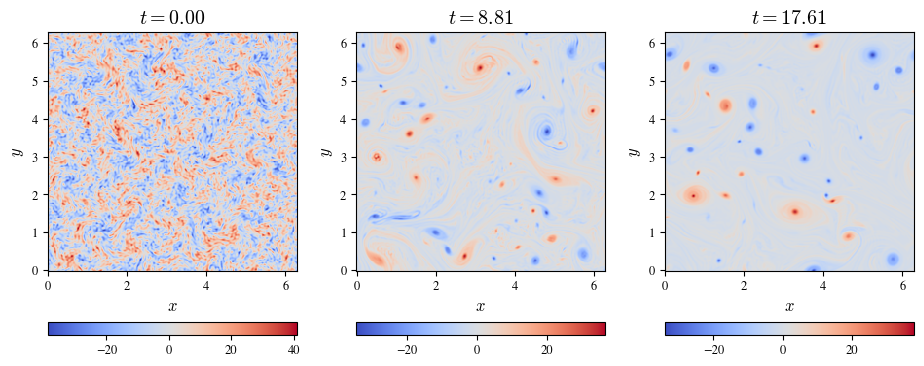

In [7]:
data_path_w = file_path + '/PyQuasiGeostrophic/geostrophic_W.csv' # vorticity (Hz)
data_path_u = file_path + '/PyQuasiGeostrophic/geostrophic_U.csv' # wind x (m/s)
data_path_v = file_path + '/PyQuasiGeostrophic/geostrophic_V.csv' # wind y (m/s)

# Read in CSV data
W = np.loadtxt(data_path_w, delimiter=',')
U = np.loadtxt(data_path_u, delimiter=',')
V = np.loadtxt(data_path_v, delimiter=',')
if noise == 0:
  W = torch.tensor(W)
  U = torch.tensor(U)
  V = torch.tensor(V)
else:
  W = add_noise(torch.tensor(W), noise)
  U = add_noise(torch.tensor(U), noise)
  V = add_noise(torch.tensor(V), noise)

# Reshape to Nx x ... x Nt tensor
[Lx, Ly, T] = [2*np.pi, 2*np.pi, 20]
[Nx, Ny, Nt] = [256, 256, 160]

W = W.view(Nx, Ny, -1).transpose(0,1)
U = U.view(Nx, Ny, -1).transpose(0,1)
V = V.view(Nx, Ny, -1).transpose(0,1)
print(f"Imported tensor with shape {U.numpy().shape}")

# Space and time
x = torch.linspace(0, Lx, Nx)
y = torch.linspace(0, Ly, Ny)
t = torch.linspace(0, T, Nt)

# Plot the data
skip = 70
X,Y = np.meshgrid(x.numpy(), y.numpy())

fig,ax = plt.subplots(1,3,figsize=(9.4,4))
for j in range(3):
  Wnp = W[:,:,skip*j].numpy()
  im = ax[j].pcolormesh(X, Y, Wnp.T, cmap='coolwarm')
  plt.colorbar(im, orientation='horizontal')
  ax[j].set_xlabel('$x$')
  ax[j].set_ylabel('$y$')
  ax[j].set_title(f'$t = {t[skip*j]:.2f}$')

fig.tight_layout()
plt.show()

del X,Y,Lx,Ly,T,Nx,Ny,Nt
del skip,j,Wnp,fig,ax,im
del data_path_w,data_path_u,data_path_v

We'll first try to discover a governing equation for the divergence $\nabla \cdot \boldsymbol{u}$

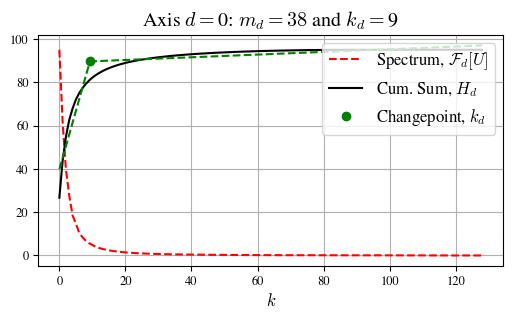

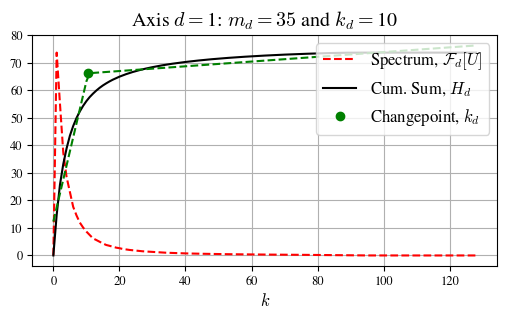

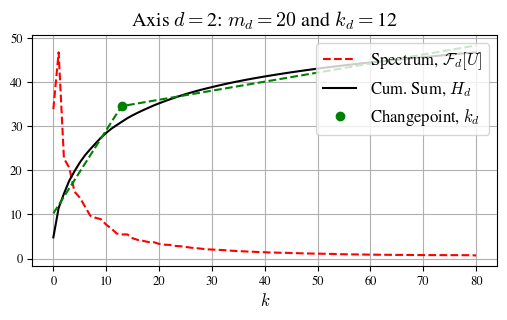

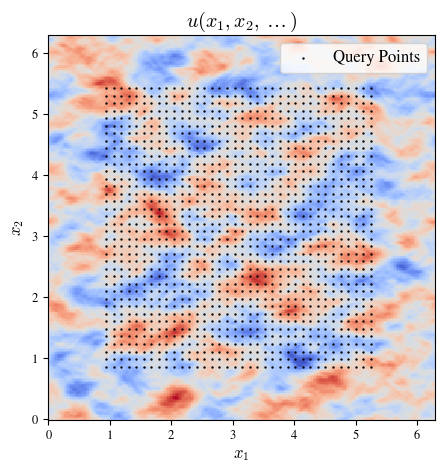

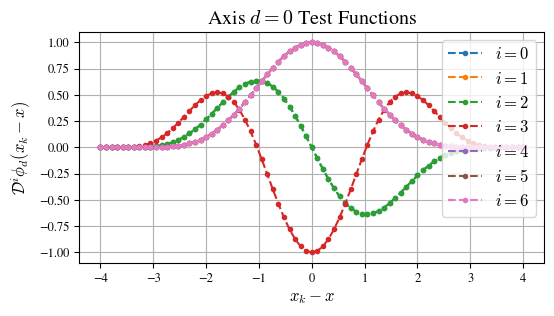

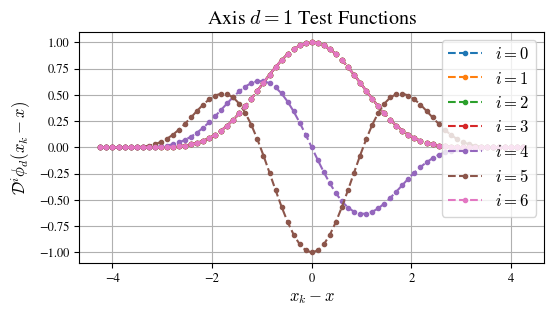

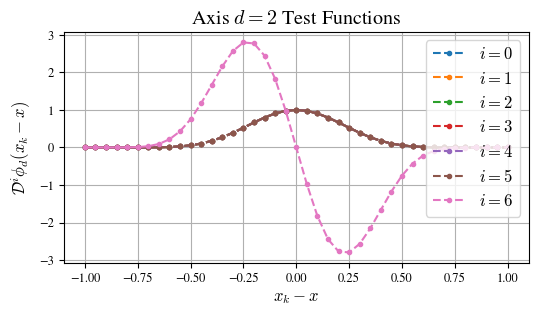

In [8]:
X = [x,y,t]

vars = [V]
names = ['u','v']

# Derivatives for test fcns
alpha = [[1,0,0], # d/dx (lhs)
         [0,0,0], # 1
         [1,0,0], # d/dx
         [2,0,0], # d^2/dx^2
         [0,1,0], # d/dy
         [0,2,0], # d^2/dy^2
         [0,0,1]] # d/dt

# Powers for homogeneous fcns
beta = [[0,0], # 1
        [1,0], # u
        [2,0], # u^2
        [0,1], # v
        [0,2], # v^2
        [1,1]] # u * v

model = WSINDy(U, alpha, beta, X, V=vars, names=names)

In [9]:
# Create standard library terms
[G,powers,derivs,rhs_names] = model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r', \, '.join(rhs_names) + r'\}'))

100%|██████████| 6/6 [00:43<00:00,  7.30s/it]


<IPython.core.display.Math object>

In [10]:
# Trim out the redundant u_x term
remove_cols = [6]
print(f'Removing: {rhs_names[6]}\n')

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
del remove_cols,column

Removing: (u)_{x}



<IPython.core.display.Math object>

In [11]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [38, 35, 20]
p = [8, 9, 10]
s = [5, 5, 3]
[yx, yt] = [4.272, 4.92, 0.397]
yu = 0.940
Aux. scales = [0.909]

LIBRARY
Num. query points = 54720
Num. terms = 30
cond(G) = 2.890e+01

RESULTS
PDE: u_{x} = - 1.00(v)_{y}
Nonzero terms = 1
Rel. L2 error = 0.000
R^2 = 1.000
Lambda = 1.000e-04
Loss = 0.033


In [12]:
# We discovered that the fluid is incompressible!
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [13]:
# Compare to known true weights
w_true = torch.zeros_like(w)
w_true[17] = -1

E2 = (w-w_true).norm() / w_true.norm()
Einf = abs(w-w_true).max() / abs(w_true).max()

print(f'E2 error = {E2}')
print(f'E∞ error = {Einf}')
print(f'TPR = {compute_tpr(w, w_true)}')

E2 error = 3.0340174816956278e-12
E∞ error = 3.0340174816956278e-12
TPR = 1.0


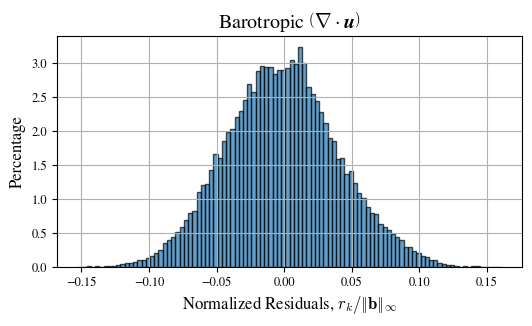

In [14]:
# Plot residuals, r = lhs - library*w
r = model.lhs - model.library @ model.coeffs
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

plt.figure(figsize=(6,3))
plt.grid(True)
plt.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
plt.title(r'Barotropic $\left(\nabla\cdot\boldsymbol{u}\right)$')
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.show()

Now we'll try to discover an evolution equation for $\zeta$

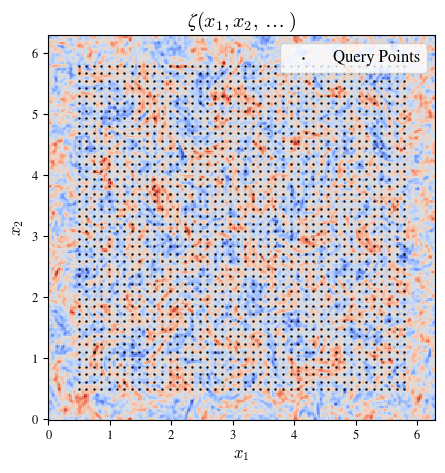

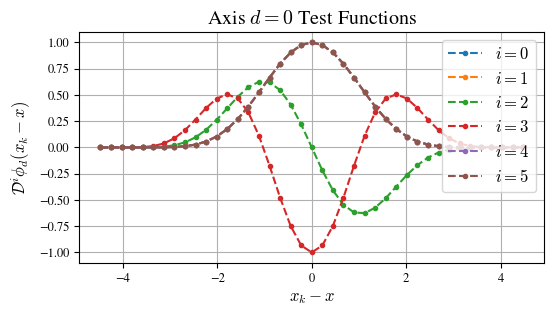

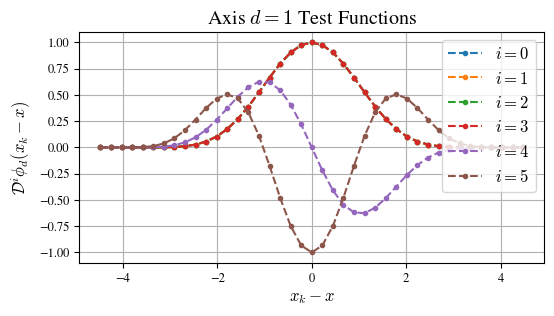

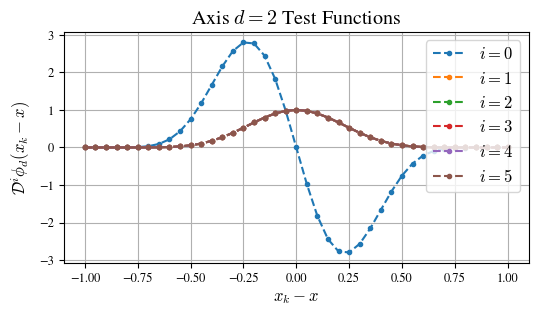

In [15]:
X = [x,y,t]

vars = [U,V]
names = ['ζ','u','v']

# Derivatives for test fcns
alpha = [[0,0,1],
         [0,0,0],
         [1,0,0],
         [2,0,0],
         [0,1,0],
         [0,2,0]]

# Powers for homogeneous fcns
beta = [[0,0,0],
        [1,0,0],
        [2,0,0],
        [0,1,0],
        [0,2,0],
        [0,0,1],
        [0,0,2],
        [1,1,0],
        [1,0,1],
        [0,1,1],]

m = [20,20,20]

model = WSINDy(W, alpha, beta, X, V=vars, names=names, m=m)

In [16]:
# Create standard library terms
[G, powers, derivs, rhs_names] = model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))

100%|██████████| 5/5 [01:12<00:00, 14.57s/it]


<IPython.core.display.Math object>

In [17]:
# Trim collinear terms from library
remove_cols = []

# We saw that u_x = - v_y
print(f'Removing: {rhs_names[12]}, {rhs_names[14]}')
remove_cols += [12, 14]

# Note that ζ := ∇ x (u,v) = u_y - v_x
print(f'Removing: {rhs_names[30]}, {rhs_names[32]}\n')
remove_cols += [30, 32]

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
del remove_cols,column

Removing: (u)_{x}, (v)_{x}
Removing: (u)_{y}, (v)_{y}



<IPython.core.display.Math object>

In [18]:
# Augment the library to include an advection term, (u·∇)ζ
print(f'Combining: {rhs_names[14]}, {rhs_names[31]}')

columns = [14,31]
coeffs = [1,1]
name = '(𝘂·∇)ζ'
info = [G, powers, derivs, rhs_names]

[G,powers,derivs,rhs_names] = composite_term(columns, coeffs, name, model, info)

Combining: (ζ u)_{x}, (ζ v)_{y}


In [19]:
# Set lhs
lhs_name = 'ζ' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [20, 20, 20]
p = [10, 10, 10]
s = [5, 5, 3]
[yx, yt] = [9.075, 9.075, 0.397]
yu = 0.248
Aux. scales = [0.94, 0.909]

LIBRARY
Num. query points = 77440
Num. terms = 41
cond(G) = 3.727e+04

RESULTS
PDE: ζ_{t} = - 1.00(𝘂·∇)ζ
Nonzero terms = 1
Rel. L2 error = 0.020
R^2 = 1.000
Lambda = 3.393e-02
Loss = 0.031


In [20]:
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [21]:
# Compare to known true weights
w_true = torch.zeros_like(w)
w_true[-1] = -1

E2 = (w-w_true).norm() / w_true.norm()
Einf = abs(w-w_true).max() / abs(w_true).max()

print(f'E2 error = {E2:.3e}')
print(f'E∞ error = {Einf:.3e}')
print(f'TPR = {compute_tpr(w, w_true):.3f}')

E2 error = 2.635e-03
E∞ error = 2.635e-03
TPR = 1.000


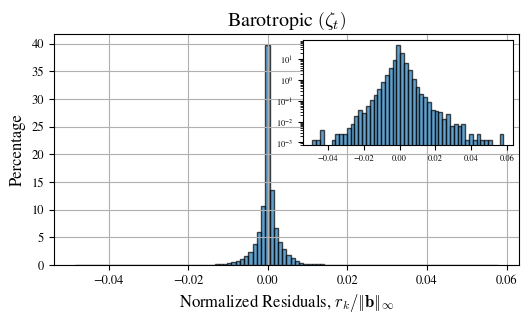

In [22]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot residuals, r = lhs - library*w
r = model.lhs - model.library @ model.coeffs
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

fig, ax = plt.subplots(figsize=(6,3))
ax.grid(True)
n, bins, patches = ax.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
ax.set_title(r'Barotropic $\left(\zeta_t\right)$')
ax.set_xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
ax.set_ylabel('Percentage')

inset = fig.add_axes([0.54, 0.51, 0.35, 0.35])
inset.hist(r/b_inf, bins=50, edgecolor='k', alpha=0.7, weights=weights)
inset.set_yscale('log')
inset.tick_params(axis='both', which='both', labelsize=6)
plt.show()

In [23]:
# Reset variables for next example
del E2,Einf, columns,info
del U,V,W, model, X,x,y,t, alpha,beta
del powers,derivs, name,lhs_name,rhs_names
del G,w,w_true, noise,pde
del b_inf,coeffs,m,r,names,vars,weights

## **SPHERICAL SHALLOW WATER EQUATIONS**

In this example, we use data from a numerical solution to the SWEs describing the height $h$ and velocity $\boldsymbol{u}$ of a fluid layer on the surface of a sphere of radius $r=1$: \begin{align*}
\begin{cases}
h_t \!\!\!\! &= - \nabla\cdot(h\boldsymbol{u}) - H_0(\nabla\cdot\boldsymbol{u}) - \nu\Delta^2h, \\
\boldsymbol{u}_t \!\!\!\! &= -(\boldsymbol{u}\cdot\nabla)\boldsymbol{u} - \boldsymbol{f}\times\boldsymbol{u} - g\nabla{h} - \nu\Delta^2\boldsymbol{u}
\end{cases}
\quad \text{where} \quad
\begin{cases}
H_0 = 1.57\cdot{10^{-3}}, \\
\nu = 8.66\cdot{10^{-9}}, \\
g = 19.947, \\
\boldsymbol{f} = 2\Omega\sin(\theta)\hat{\mathbf{z}},\\
\Omega = 0.263.
\end{cases}
\end{align*} The data were sourced from [this Dedalus example](https://dedalus-project.readthedocs.io/en/latest/pages/examples/ivp_sphere_shallow_water.html), inspired by [Galewsky et al](https://www.tandfonline.com/doi/abs/10.3402/tellusa.v56i5.14436).
\
Two notes here:
- this example investigates term-wise accuracy; that is, we feed *direct* measurements of the above terms into the library ($\boldsymbol{f} \times \boldsymbol{u}$, etc.), amongst many others, and see if WSINDy recovers the correct terms.
- we consider the hyperviscosity terms $\Delta^2h$ and $\Delta^2\boldsymbol{u}$ to be numerical stability terms (i.e., these are not counted towards $\mathbf{w}_{\rm{true}}$).

In [ ]:
noise = 0.

In [ ]:
# Simulation units
meter = 1 / 6.37122e6
hour = 1
second = hour / 3600

# True Parameters
R = 6.37122e6 * meter
Omega = 7.292e-5 / second
nu = 1e5 * meter**2 / second / 32**2
g = 9.80616 * meter / second**2
H0 = 1e4 * meter

Imported tensor with shape (256, 128, 360)
Trimmed to shape (256, 112, 360)


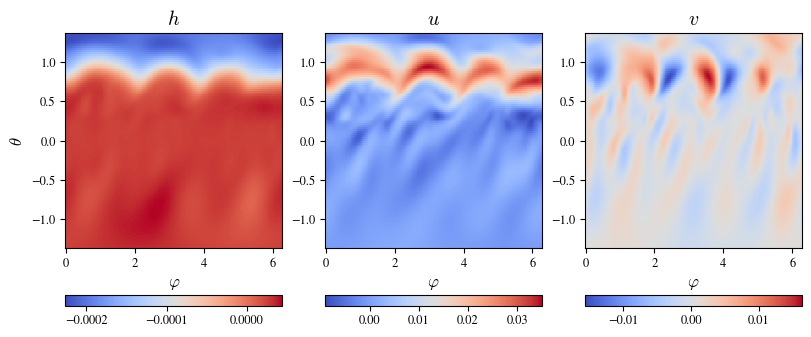

In [ ]:
data_paths = []

# Raw measurements
data_paths.append(file_path + '/Dedalus/height.csv') # height
data_paths.append(file_path + '/Dedalus/u.csv') # u
data_paths.append(file_path + '/Dedalus/v.csv') # v

# Observed forces
data_paths.append(file_path + '/Dedalus/div.csv') # ∇·𝘂
data_paths.append(file_path + '/Dedalus/total_div.csv') # ∇·(h𝘂)
data_paths.append(file_path + '/Dedalus/advect_u.csv') # (𝘂·∇)𝘂_1
data_paths.append(file_path + '/Dedalus/advect_v.csv') # (𝘂·∇)𝘂_2
data_paths.append(file_path + '/Dedalus/grad_u.csv') # ∇h_1
data_paths.append(file_path + '/Dedalus/grad_v.csv') # ∇h_2

# Hyperviscosities (numerical stability terms)
data_paths.append(file_path + '/Dedalus/hyper_h.csv')
data_paths.append(file_path + '/Dedalus/hyper_u.csv')
data_paths.append(file_path + '/Dedalus/hyper_v.csv')

# Read in CSV data and reshape to Nx x ... x Nt tensor
[Nx, Ny, Nt] = [256, 128, 360]
U_list = []
for i,path in enumerate(data_paths):
  U_list.append(add_noise(torch.tensor(np.loadtxt(path, delimiter=',')), noise))
  U_list[i] = U_list[i].view(Nx, Ny, -1)
#[H,U,V,Div,Flux,AdvectU,AdvectV,Grad1,Grad2,HyperH,HyperU,HyperV]
[H,U,V,Div,Flux,HyperH] = U_list

print(f"Imported tensor with shape {U.numpy().shape}")

# Space and time
x = torch.linspace(0, 6.25864161, Nx)
y = torch.linspace(0.01871455, 3.12287811, Ny) - np.pi/2
t = torch.linspace(0., 359., Nt)

# Cut out polar latitudes to avoid singularities
[bot, top] = [8, 8]
y = y[bot:-top]
H = H[:,bot:-top,:]
U = U[:,bot:-top,:]
V = V[:,bot:-top,:]
Div = Div[:,bot:-top,:]
Flux = Flux[:,bot:-top,:]
AdvectU = AdvectU[:,bot:-top,:]
AdvectV = AdvectV[:,bot:-top,:]
Grad1 = Grad1[:,bot:-top,:]
Grad2 = Grad2[:,bot:-top,:]
HyperH = HyperH[:,bot:-top,:]
HyperU = HyperU[:,bot:-top,:]
HyperV = HyperV[:,bot:-top,:]
print(f"Trimmed to shape {U.numpy().shape}")

# Create plot
[X, Y, T] = torch.meshgrid(x,y,t, indexing='ij')
fig,ax = plt.subplots(1,3,figsize=(9.5,4))
for i in range(3):
  im = ax[i].pcolormesh(X[:,:,-1], Y[:,:,-1], [H,U,V][i][:,:,-1], cmap='coolwarm')
  ax[i].set_title(['$h$','$u$','$v$'][i])
  ax[i].set_xlabel(r'$\varphi$')
  if i == 0:
    ax[i].set_ylabel(r'$\theta$')
  fig.colorbar(im, orientation='horizontal')
plt.show()

# Define the Coriolis force and spherical Jacobian
Jacobian = R**2 * torch.cos(Y)
omega = 0.263
[fu, fv] = [2*Omega*torch.sin(Y)*U, 2*Omega*torch.sin(Y)*V]

del X, Y, T, U_list, top, bot
del fig, ax, im

Let's try to discover an evolution equation for $h$

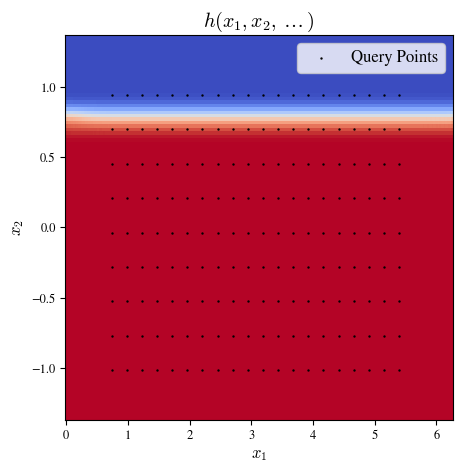

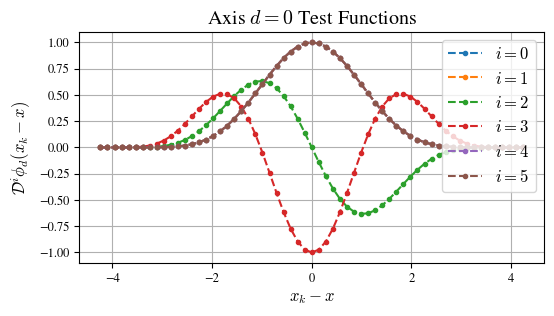

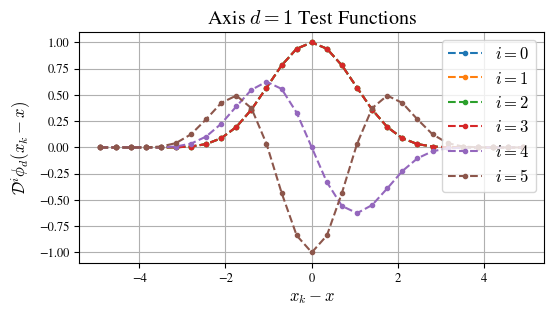

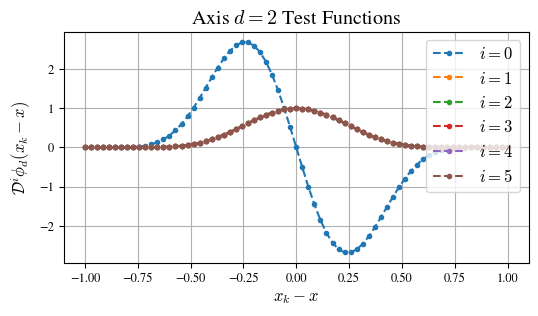

In [ ]:
X = [x,y,t]

vars = [U, V, Div, Flux, nu*HyperH]
names = ['h','u','v','∇·𝘂','∇·(h𝘂)','νΔ^2h']

# Derivatives for test fcns
alpha = [[0,0,1], # d/dt
         [0,0,0], # 1
         [1,0,0], # d/dx
         [2,0,0], # d^2/dx^2
         [0,1,0], # d/dy
         [0,2,0]] # d^2/dy^2

# Powers for homogeneous fcns
beta = [[0,0,0,0,0,0], # 1
        [1,0,0,0,0,0], # h
        [2,0,0,0,0,0], # h^2
        [0,1,0,0,0,0], # u
        [0,2,0,0,0,0], # u^2
        [0,0,1,0,0,0], # v
        [0,0,2,0,0,0], # v^2
        [1,1,0,0,0,0], # h*u
        [1,0,1,0,0,0], # h*v
        [0,1,1,0,0,0], # u*v
        [0,0,0,1,0,0], # ∇·𝘂
        [0,0,0,0,1,0], # ∇·(h𝘂)
        [0,0,0,0,0,1]] # 'Δ^2h'

m = [30, 14, 35]
s = [10, 10, 14]

model = WSINDy(H, alpha, beta, X, V=vars, names=names, m=m, s=s, jacobian=Jacobian)

In [ ]:
model.aux_scales = model.aux_scales[0:3] + [690, 1270]

In [ ]:
# Create standard library terms
[G, powers, derivs, rhs_names] = model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))

100%|██████████| 5/5 [02:17<00:00, 27.49s/it]


<IPython.core.display.Math object>

In [ ]:
# Set lhs
lhs_name = 'h' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [30, 14, 35]
p = [9, 12, 9]
s = [10, 10, 14]
[yx, yt] = [5.762, 14.316, 0.029]
yu = 80.722
Aux. scales = [5.697, 8.644, 21.355, 690.0, 1270.0]

LIBRARY
Num. query points = 3780
Num. terms = 61
cond(G) = 1.040e+07

RESULTS
PDE: h_{t} = - 0.00(∇·𝘂) - 1.00(∇·(h𝘂))
Nonzero terms = 2
Rel. L2 error = 0.006
R^2 = 1.000
Lambda = 6.251e-03
Loss = 0.039


In [ ]:
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [ ]:
# Compare to known true weights
w_true = torch.zeros_like(w)
w_true[10] = -H0
w_true[11] = -1.

E2 = (w-w_true).norm() / w_true.norm()
Einf = abs(w-w_true).max() / abs(w_true).max()

print(f'E2 error = {E2:.3e}')
print(f'E∞ error = {Einf:.3e}')
print(f'TPR = {compute_tpr(w, w_true)}')

E2 error = 8.129e-04
E∞ error = 8.129e-04
TPR = 1.0


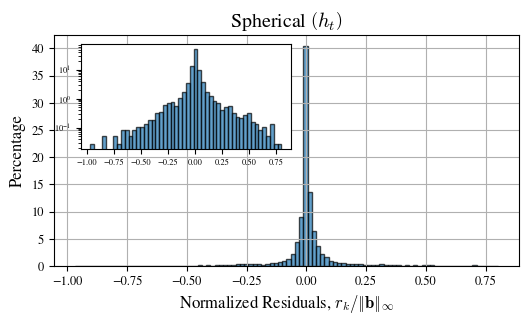

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Plot residuals, r = lhs - library*w
r = model.lhs - model.library @ model.coeffs
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

fig, ax = plt.subplots(figsize=(6,3))
ax.grid(True)
n, bins, patches = ax.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
ax.set_title(r'Spherical $\left(h_t\right)$')
ax.set_xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
ax.set_ylabel('Percentage')

inset = fig.add_axes([0.17, 0.5, 0.35, 0.35])
inset.hist(r/b_inf, bins=50, edgecolor='k', alpha=0.7, weights=weights)
inset.set_yscale('log')
inset.tick_params(axis='both', which='both', labelsize=6)
plt.show()

Now we'll go for momentum equations for $u$ and $v$

In [ ]:
X = [x,y,t]

u_vars = [V, AdvectU, fv, Grad1, HyperU]
u_names = ['u','v','(𝘂·∇)u','fv','∇h_1','Δ^2u']

v_vars = [U, AdvectV, fu, Grad2, HyperV]
v_names = ['v','u','(𝘂·∇)v','fu','∇h_2','Δ^2v']

# Derivatives for test fcns
alpha = [[0,0,1], # d/dt
         [0,0,0], # 1
         [1,0,0], # d/dx
         [2,0,0], # d^2/dx^2
         [0,1,0], # d/dy
         [0,2,0]] # d^2/dy^2

# Powers for homogeneous fcns
beta = [[0,0,0,0,0,0],
        [1,0,0,0,0,0],
        [2,0,0,0,0,0],
        [0,1,0,0,0,0],
        [0,2,0,0,0,0],
        [0,0,1,0,0,0],
        [0,0,0,1,0,0],
        [0,0,0,0,1,0],
        [0,0,0,0,0,1],]

m = [30, 14, 35]
s = [10, 10, 14]

u_model = WSINDy(U, alpha, beta, X, V=u_vars, names=u_names, m=m, s=s, jacobian=Jacobian, verbosity=False)
v_model = WSINDy(V, alpha, beta, X, V=v_vars, names=v_names, m=m, s=s, jacobian=Jacobian, verbosity=False)

In [ ]:
# Create standard library terms
u_model.aux_scales = u_model.aux_scales[0:2] + [14, 60, 0.01]
[G1, powers1, derivs1, rhs_names1] = u_model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names1) + r'\}'))

v_model.aux_scales = v_model.aux_scales[0:3] + [39, 0.01]
[G2, powers2, derivs2, rhs_names2] = v_model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names2) + r'\}'))

100%|██████████| 5/5 [01:24<00:00, 16.89s/it]


<IPython.core.display.Math object>

100%|██████████| 5/5 [01:25<00:00, 17.08s/it]


<IPython.core.display.Math object>

In [ ]:
# Set lhs
u_model.build_lhs('u' + u_model.derivative_names[0])

# Set library
u_model.set_library(G1, powers1, derivs1, rhs_names1)

# Find sparse weights
w1 = u_model.MSTLS()
u_model.print_report()

HYPER-PARAMETERS
m = [30, 14, 35]
p = [9, 12, 9]
s = [10, 10, 14]
[yx, yt] = [5.762, 14.316, 0.029]
yu = 5.697
Aux. scales = [8.644, 27.625, 14.0, 60.0, 0.01]

LIBRARY
Num. query points = 3780
Num. terms = 41
cond(G) = 7.082e+04

RESULTS
PDE: u_{t} = - 1.00((𝘂·∇)u) - 1.00(fv) - 19.96(∇h_1)
Nonzero terms = 3
Rel. L2 error = 0.012
R^2 = 1.000
Lambda = 5.429e-04
Loss = 0.086


In [ ]:
# Set lhs
v_model.build_lhs('v' + v_model.derivative_names[0])

# Set library
v_model.set_library(G2, powers2, derivs2, rhs_names2)

# Find sparse weights
w2 = v_model.MSTLS()
v_model.print_report()

HYPER-PARAMETERS
m = [30, 14, 35]
p = [9, 12, 9]
s = [10, 10, 14]
[yx, yt] = [5.762, 14.316, 0.029]
yu = 8.644
Aux. scales = [5.697, 18.427, 1.0, 39.0, 0.01]

LIBRARY
Num. query points = 3780
Num. terms = 41
cond(G) = 1.087e+05

RESULTS
PDE: v_{t} = - 1.00((𝘂·∇)v) + 1.00(fu) - 19.94(∇h_2)
Nonzero terms = 3
Rel. L2 error = 0.002
R^2 = 1.000
Lambda = 1.389e-03
Loss = 0.075


In [ ]:
pde1 = symbolic_pde(u_model.lhs_name, u_model.rhs_names, u_model.coeffs)
pde2 = symbolic_pde(v_model.lhs_name, v_model.rhs_names, v_model.coeffs)
display(Math(pde1))
display(Math(pde2))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [ ]:
# Compare to known true weights (u)
w1_true = torch.zeros_like(w1)
w1_true[5] = -1
w1_true[6] = -1
w1_true[7] = -g

E2 = (w1-w1_true).norm() / w1_true.norm()
Einf = abs(w1-w1_true).max() / abs(w1_true).max()

print(f'E2 error = {E2:.3e}')
print(f'E∞ error = {Einf:.3e}')
print(f'TPR = {compute_tpr(w1, w1_true)}')

E2 error = 8.303e-04
E∞ error = 8.309e-04
TPR = 1.0


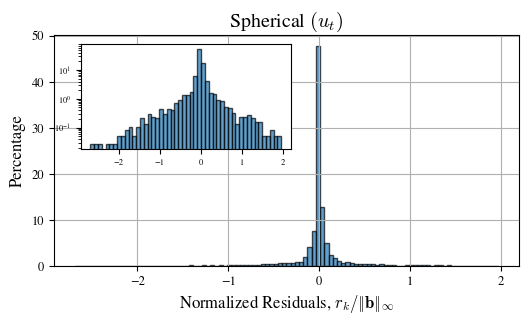

In [ ]:
# Plot residuals, r = lhs - library*w
r = u_model.lhs - u_model.library @ u_model.coeffs
b_inf = abs(u_model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

fig, ax = plt.subplots(figsize=(6,3))
ax.grid(True)
n, bins, patches = ax.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
ax.set_title(r'Spherical $(u_t)$')
ax.set_xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
ax.set_ylabel('Percentage')

inset = fig.add_axes([0.17, 0.5, 0.35, 0.35])
inset.hist(r/b_inf, bins=50, edgecolor='k', alpha=0.7, weights=weights)
inset.set_yscale('log')
inset.tick_params(axis='both', which='both', labelsize=6)
plt.show()

In [ ]:
# Compare to known true weights (v)
w2_true = torch.zeros_like(w2)
w2_true[5] = -1
w2_true[6] = +1
w2_true[7] = -g

E2 = (w2-w2_true).norm() / w2_true.norm()
Einf = abs(w2-w2_true).max() / abs(w2_true).max()

print(f'E2 error = {E2:.3e}')
print(f'E∞ error = {Einf:.3e}')
print(f'TPR = {compute_tpr(w2, w2_true)}')

E2 error = 2.312e-04
E∞ error = 2.317e-04
TPR = 1.0


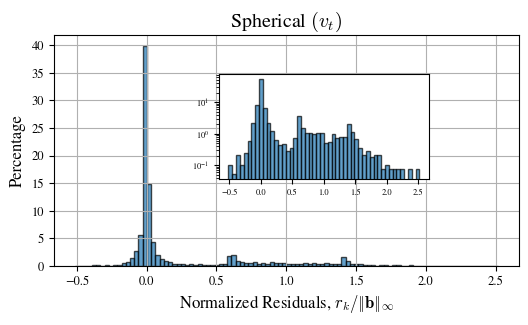

In [ ]:
# Plot residuals, r = lhs - library*w
r = v_model.lhs - v_model.library @ v_model.coeffs
b_inf = abs(v_model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

fig, ax = plt.subplots(figsize=(6,3))
ax.grid(True)
n, bins, patches = ax.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
plt.title(r'Spherical $(v_t)$')
ax.set_xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
ax.set_ylabel('Percentage')

inset = fig.add_axes([0.4, 0.4, 0.35, 0.35])
inset.hist(r/b_inf, bins=50, edgecolor='k', alpha=0.7, weights=weights)
inset.set_yscale('log')
inset.tick_params(axis='both', which='both', labelsize=6)
plt.show()

## **STABLY STRATIFIED BOUNDARY LAYER**

Here, we use data from a large-eddy simulation of the Boussinesq equations in $(3+1)$-dimensions: \begin{align*}
\begin{cases}
\boldsymbol{u}_t + (\boldsymbol{u}\cdot\nabla)\boldsymbol{u} = -\boldsymbol{f}\times(\boldsymbol{u}-\boldsymbol{u}_g) - \nabla p + \beta(\theta - \theta_0) - \nabla\cdot\mathbf{T},
\\
\theta_t + (\boldsymbol{u}\cdot\nabla)\theta = -\nabla\cdot\mathbf{B},
\\
\nabla\cdot\boldsymbol{u} = 0
\end{cases}
\quad \text{where} \quad
\begin{cases}
\text{T}_{ij} = \langle u'_iu_j' \rangle - u_iu_j,
\\
\text{B}_{i} = \langle u_i'\theta' \rangle - u_i\theta.
\end{cases}
\end{align*} These data were sourced from [the Johns Hopkins Turbulence Database](https://turbulence.idies.jhu.edu/datasets/geophysicalTurbulence/sabl); see [the paper by McWilliams et al](https://www.mdpi.com/2073-4433/14/7/1107).

In [ ]:
noise = 0.

Imported tensor with shape (62, 62, 100)


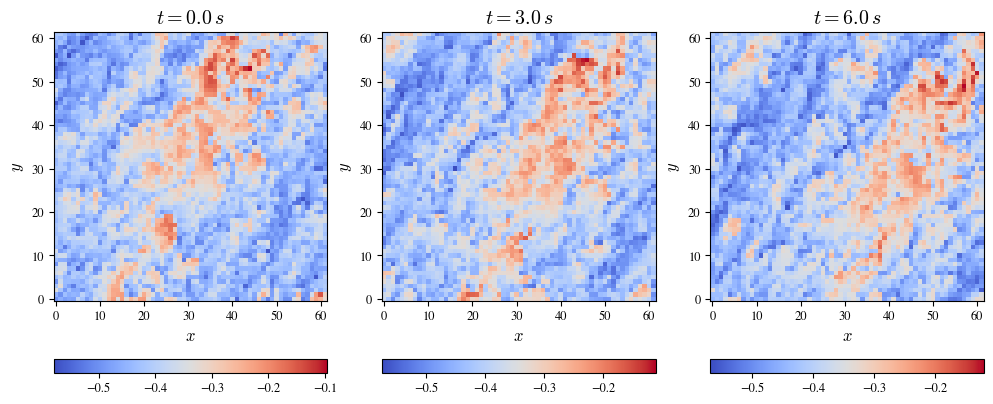

In [ ]:
# Read in CSV data
Temp = np.loadtxt(file_path + '/JHTDB/geophysical/temp (1).csv', delimiter=',')
U = np.loadtxt(file_path + '/JHTDB/geophysical/u.csv', delimiter=',')
V = np.loadtxt(file_path + '/JHTDB/geophysical/v.csv', delimiter=',')
#Tempz = np.loadtxt(file_path + 'v/temp_z.csv', delimiter=',')
#W = np.loadtxt(file_path + '/JHTDB/geophysical/w.csv', delimiter=',')
Wz = np.loadtxt(file_path + '/JHTDB/geophysical/w_z.csv', delimiter=',')
#Px = np.loadtxt(file_path + '/JHTDB/geophysical/p_x.csv', delimiter=',')
#Py = np.loadtxt(file_path + '/JHTDB/geophysical/p_y.csv', delimiter=',')

if noise == 0:
  Temp = torch.tensor(Temp)
  U = torch.tensor(U)
  V = torch.tensor(V)
  Wz = torch.tensor(Wz)
else:
  Temp = add_noise(torch.tensor(Temp), noise)
  U = add_noise(torch.tensor(U), noise)
  V = add_noise(torch.tensor(V), noise)
  Wz = add_noise(torch.tensor(Wz), noise)

# Reshape to Nx x ... x Nt tensor
[Lx, Ly, T] = [62, 62, 100*0.075]
[Nx, Ny, Nt] = [62, 62, 100]

Temp = Temp.view(Nx, Ny, -1)
U = U.view(Nx, Ny, -1)
V = V.view(Nx, Ny, -1)
Wz = Wz.view(Nx, Ny, -1)
print(f"Imported tensor with shape {U.numpy().shape}")

# Space and time
x = torch.arange(0, Nx, 1)
y = torch.arange(0, Ny, 1)
t = torch.arange(0, T, 0.075)

# Plot
X,Y = np.meshgrid(x, y, indexing='ij')
fig,ax = plt.subplots(1,3, figsize=(12,5))
for i in range(3):
  thyme = i*40
  im = ax[i].pcolormesh(X, Y, Temp[:,:,thyme].T, cmap='coolwarm')
  #ax[i].axis('off')
  plt.colorbar(im, orientation='horizontal')
  ax[i].set_xlabel('$x$')
  ax[i].set_ylabel('$y$')
  ax[i].set_title(f'$t = {0.075 * thyme} \, s$')
plt.show()

del Nx,Ny,Lx,Ly
del X,Y,thyme,fig,ax,i

For fun, let's try to discover a governing equation for the divergence $\nabla \cdot \boldsymbol{u}$

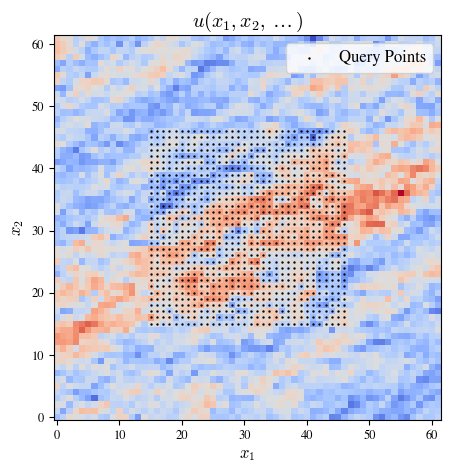

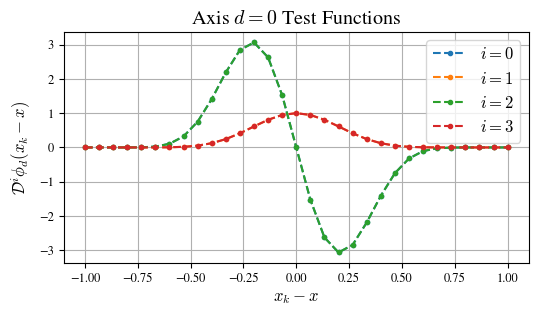

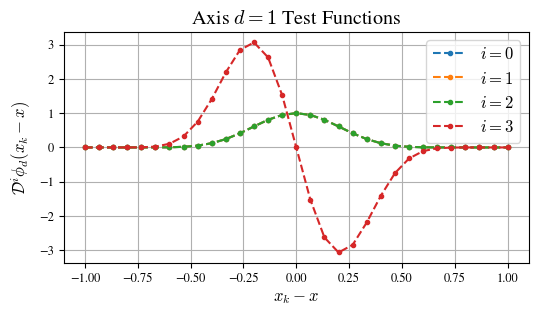

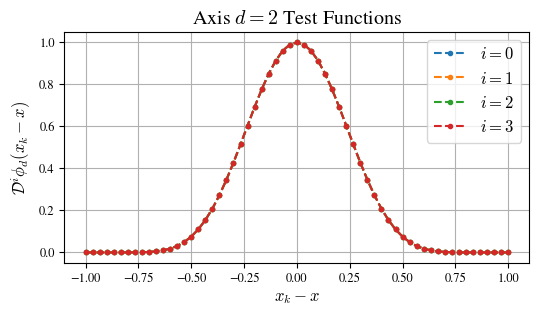

In [ ]:
X = [x,y,t]

vars = [V, Wz]
names = ['u','v','w_{z}']

# Derivatives for test fcns
alpha = [[1,0,0], # d/dx (lhs)
         [0,0,0], # 1
         [1,0,0], # d/dx
         [0,1,0]] # d/dy

# Powers for homogeneous fcns
beta = [[0,0,0],
        [1,0,0],
        [0,1,0],
        [0,0,1],]

m = [15,15,30]

model = WSINDy(U, alpha, beta, X, V=vars, names=names, m=m)

In [ ]:
# Create standard library terms
[G,powers,derivs,rhs_names] = model.create_default_library()
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))

100%|██████████| 3/3 [00:00<00:00,  7.37it/s]


<IPython.core.display.Math object>

In [ ]:
# Trim out the redundant u_x term
remove_cols = [4]
print(f'Removing: {rhs_names[4]}\n')

for column in sorted(remove_cols, reverse=True):
  G.pop(column)
  powers.pop(column)
  derivs.pop(column)
  rhs_names.pop(column)

display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))
del remove_cols,column

Removing: (u)_{x}



<IPython.core.display.Math object>

In [ ]:
# Set lhs
lhs_name = 'u' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [15, 15, 30]
p = [12, 12, 9]
s = [1, 1, 2]
[yx, yt] = [0.067, 0.067, 0.444]
yu = 1.000
Aux. scales = [1.0, 1.0]

LIBRARY
Num. query points = 20480
Num. terms = 9
cond(G) = 1.317e+02

RESULTS
PDE: u_{x} = - 0.93(w_{z}) - 0.99(v)_{y}
Nonzero terms = 2
Rel. L2 error = 0.194
R^2 = 0.962
Lambda = 5.964e-02
Loss = 0.280


In [ ]:
# Near incompressibility
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

In [ ]:
# Compare to known true weights
w_true = torch.zeros_like(w)
w_true[3] = -1
w_true[-2] = -1

E2 = (w-w_true).norm() / w_true.norm()
Einf = abs(w-w_true).max() / abs(w_true).max()

print(f'E2 error = {E2:.3e}')
print(f'E∞ error = {Einf:.3e}')
print(f'TPR = {compute_tpr(w, w_true)}')

E2 error = 5.207e-02
E∞ error = 7.277e-02
TPR = 1.0


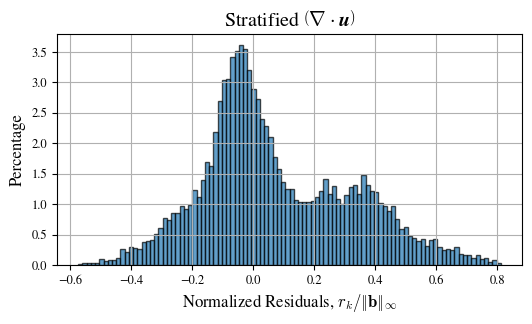

In [ ]:
# Plot residuals, r = lhs - library*w
r = model.lhs - model.library @ model.coeffs
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

plt.figure(figsize=(6,3))
plt.grid(True)
plt.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
plt.title(r'Stratified $\left(\nabla\cdot\boldsymbol{u}\right)$')
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.show()

Now we'll try to discover an evolution equation for $\vartheta$

In [ ]:
# Leave 1/3 for test data?
test_data = True
training = 67

if test_data:
  Temp = Temp[:,:,:training]
  U = U[:,:,:training]
  V = V[:,:,:training]
  Wz = Wz[:,:,:training]
  t = t[:training]

print(f'New shape {Temp.numpy().shape}')
del test_data, training

New shape (62, 62, 67)


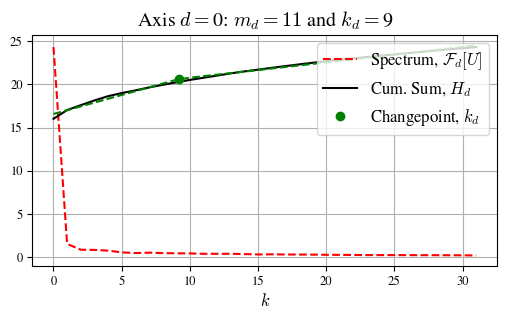

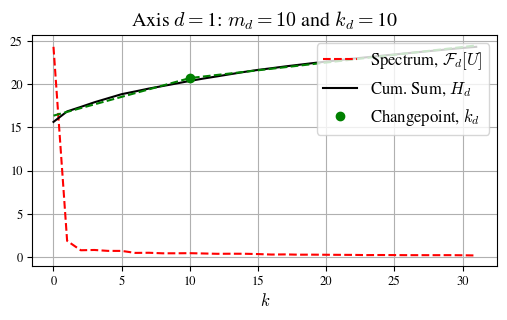

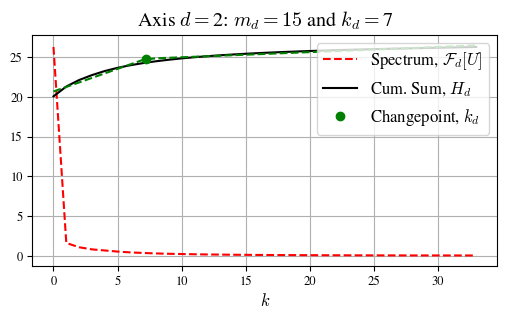

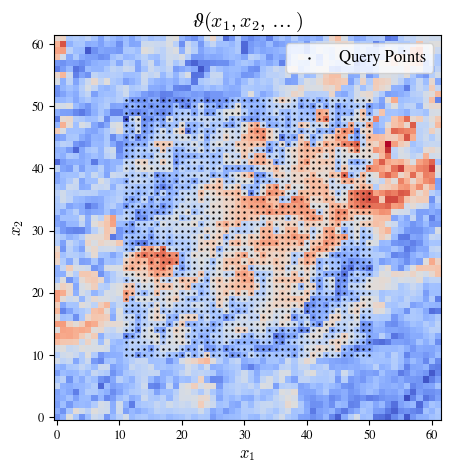

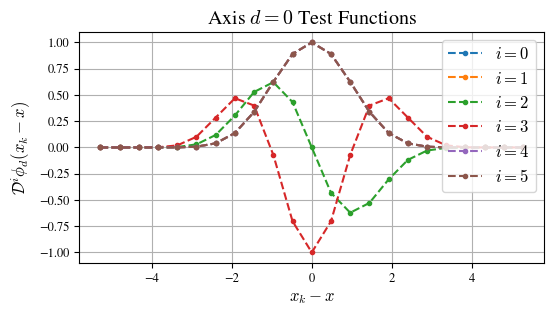

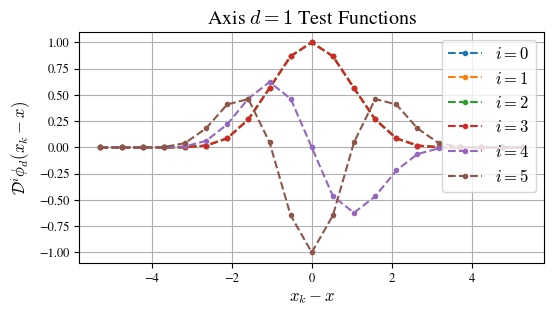

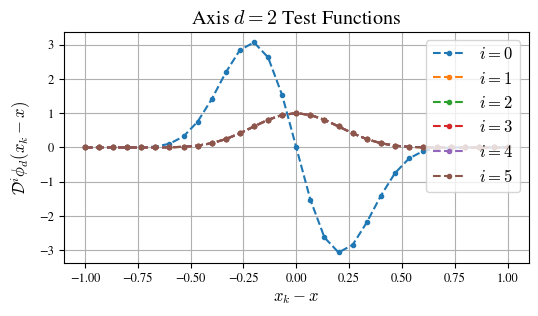

In [ ]:
X = [x,y,t]

vars = [U,V]
names = ['ϑ','u','v']

# Derivatives for test fcns
alpha = [[0,0,1],
         [0,0,0],
         [1,0,0],
         [2,0,0],
         [0,1,0],
         [0,2,0]]

# Powers for homogeneous fcns
beta = [[0,0,0],
        [1,0,0],
        [2,0,0],
        [0,1,0],
        [0,2,0],
        [0,0,1],
        [0,0,2],
        [1,1,0],
        [1,0,1],
        [0,1,1],]

#m = [10,10,20]

model = WSINDy(Temp, alpha, beta, X, V=vars, names=names)#, m=m)

In [ ]:
# Create standard library terms
[G, powers, derivs, rhs_names] = model.create_default_library()

# Augment the library to include an advection term, (u·∇)ζ
print(f'Combining: {rhs_names[16]}, {rhs_names[34]}')

columns = [12,32]
coeffs = [1,1]
name = '(u·∇)ϑ'
info = [G, powers, derivs, rhs_names]

[G,powers,derivs,rhs_names] = composite_term(columns, coeffs, name, model, info)
display(Math(r'\Theta=' + r'\{' + r',\,'.join(rhs_names) + r'\}'))

100%|██████████| 5/5 [00:00<00:00,  5.03it/s]

Combining: (ϑ u)_{x}, (ϑ u)_{y}


<IPython.core.display.Math object>

In [ ]:
# Set lhs
lhs_name = 'ϑ' + model.derivative_names[0]
model.build_lhs(lhs_name)

# Set library
model.set_library(G, powers, derivs, rhs_names)

# Find sparse weights
w = model.MSTLS()
model.print_report()

HYPER-PARAMETERS
m = [11, 10, 15]
p = [14, 14, 12]
s = [1, 1, 1]
[yx, yt] = [0.481, 0.529, 0.889]
yu = 1.534
Aux. scales = [0.666, 0.797]

LIBRARY
Num. query points = 62160
Num. terms = 45
cond(G) = 7.613e+03

RESULTS
PDE: ϑ_{t} = - 2.80(ϑ^2)_{x} - 3.11(ϑ)_{y} - 2.53(ϑ^2)_{y}
Nonzero terms = 3
Rel. L2 error = 0.225
R^2 = 0.949
Lambda = 1.048e-01
Loss = 0.181


In [ ]:
# Traveling wave model
pde = symbolic_pde(model.lhs_name, model.rhs_names, model.coeffs)
display(Math(pde))

<IPython.core.display.Math object>

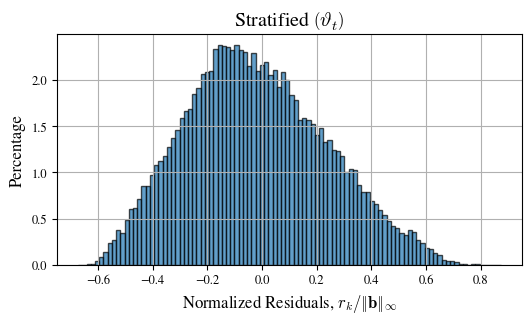

In [ ]:
# Plot residuals, r = lhs - library*w
r = model.lhs - model.library @ model.coeffs
b_inf = abs(model.lhs).max().item()
weights = 100*torch.ones_like(r)/len(r)

plt.figure(figsize=(6,3))
plt.grid(True)
plt.hist(r/b_inf, bins=100, edgecolor='k', alpha=0.7, weights=weights)
plt.title(r'Stratified $\left(\vartheta_t\right)$')
plt.xlabel(r'Normalized Residuals, $r_k/|\!|\mathbf{b}|\!|_{\infty}$')
plt.ylabel('Percentage')
plt.show()